Simulate 2body coupling with PA and plot time evolution of wigner function.

In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import Qsim.operator.spin as spin
import Qsim.operator.phonon as phon
import Qsim.ion_chain.ising.ising_ps as iscp
import Qsim.ion_chain.ising.ising_c as iscc
import Qsim.operator.spin_phonon as sp_op
import Qsim.ion_chain.interaction.spin_phonon as Isp
from  Qsim.ion_chain.ion_system import *
from scipy import signal
import Qsim.auxiliay_function.wigner as wg
import os

In [6]:
delta = 25
ion_sys = ions(trap_config={'N': 2, 'fx': 3, 'fz': 1}, 
                   numeric_config={'active_spin': [0, 1],'active_phonon': [[0,1]], 'pcut': [[50,50]]},
                   )
ion_sys.list_para() #print parameters of the system
laser1 = Laser(config = {'Omega_eff':30,'wavevector':1,'Dk':np.sqrt(2)*2*np.pi / (355*10**(-9)),
                         'laser_couple':[0,1], 'mu':delta+1e3*ion_sys.fx,'phase':0})
laser1.list_para()
Bz = 0 #Effective magnetic field
N = ion_sys.N

Trap coefficients updated
Anharmonic coefficients updated
_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
Cooling parameters updated
Trap parametric modulation updated
Ions class object initialized.
________________________________________________________________
********************Setup of the Trap************************
number of ions 2
Axial COM (Confining) frequency  1  [MHz]
Radial COM (Confining) frequency  3 [MHz]
Axial vibrational eigenfrequency [1.   1.73] MHz
Radial (Transverse) vibrational eigenfrequency [3.   2.83] [MHz]
Modulation Amplitude for parameteric amplification:  0 [V]
Modulation Frequency for parameteric amplification:  0 [MHz]
Trap dimension parameter:  200 [um]
                                                                 
********************Config of Numeric Calculation*****************

In [7]:
#%% construct states and operators 
spin_config = np.array([0,0])
psi1 = sp_op.ini_state(ion_sys,spin_config,[[0,0]],1)
rho1 = sp_op.ini_state(ion_sys,spin_config,[[0,0]],0)
elist2 = [tensor(spin.sz(N,0),sp_op.p_I(ion_sys)),tensor(spin.sz(N,1),sp_op.p_I(ion_sys))]
#projection operators
up = basis(2,0)
down = basis(2,1)
s1 = (basis(2,0)+basis(2,1))/np.sqrt(2) #|++>
s2 = (basis(2,0)-basis(2,1))/np.sqrt(2) #|-->
splus = tensor(s1,s1) ; sminus = tensor(s2,s2)
proj1=tensor(splus*splus.dag(),sp_op.p_I(ion_sys))
proj2=tensor(sminus*sminus.dag(),sp_op.p_I(ion_sys))

In [8]:
#%% set PA parameters, set V_mod to 0 for dynamics without PA
ion_sys.update_PM(para_mod_config = {'f_mod':2*(ion_sys.fx*1000+delta) ,'V_mod':0.1,'d_T':200})
ion_sys.list_para() #print parameters of the system
print('Predicted phonon osicllation frequency, [kHz]')
gcoef = ion_sys.PA_coef(1,0)/(2*np.pi)
delta1 = np.sqrt(delta**2 - gcoef**2 )
print(delta1)

Trap parametric modulation updated
________________________________________________________________
********************Setup of the Trap************************
number of ions 2
Axial COM (Confining) frequency  1  [MHz]
Radial COM (Confining) frequency  3 [MHz]
Axial vibrational eigenfrequency [1.   1.73] MHz
Radial (Transverse) vibrational eigenfrequency [3.   2.83] [MHz]
Modulation Amplitude for parameteric amplification:  0.1 [V]
Modulation Frequency for parameteric amplification:  6050 [MHz]
Trap dimension parameter:  200 [um]
                                                                 
********************Config of Numeric Calculation************************
index of phonon space included in simulation:  [[0, 1]]
corresonding phonon space cutoff  [[50, 50]]
********************Config of Cooling************************
Effective cooling rate  [2. 2.]  [kHz]
Coolant index  [1]
********************Config of Trap Modulation************************
 Modulation Amplitude 0.1  [V]


In [9]:
#%% Construct Hamiltonain
times =  np.arange(0,0.1,10**(-4))
Heff,arg0 = iscc.H_ord(Bz,ion_sys,laser1)
H_PA_com, arg_Hpa = Isp.H_PA_td(ion_sys)
Heff2 = Heff + H_PA_com; arg2 = arg0 | arg_Hpa
#solve time dependent SE
print('______________________________________________________________________')
print('solving for complete Hamiltonian')
result2 = sesolve(Heff2,psi1,times,args = arg2,progress_bar=True,options=Options(nsteps=10000))
#result2 = mesolve(Heff2,rho1,times,args = arg2,progress_bar=True,options=Options(nsteps=10000))  

______________________________________________________________________
solving for complete Hamiltonian
10.0%. Run time:   3.08s. Est. time left: 00:00:00:27
20.0%. Run time:   6.60s. Est. time left: 00:00:00:26
30.0%. Run time:  10.20s. Est. time left: 00:00:00:23
40.0%. Run time:  13.52s. Est. time left: 00:00:00:20
50.0%. Run time:  16.56s. Est. time left: 00:00:00:16
60.0%. Run time:  19.83s. Est. time left: 00:00:00:13
70.0%. Run time:  23.55s. Est. time left: 00:00:00:10
80.0%. Run time:  27.07s. Est. time left: 00:00:00:06
90.0%. Run time:  30.25s. Est. time left: 00:00:00:03
Total run time:  33.63s


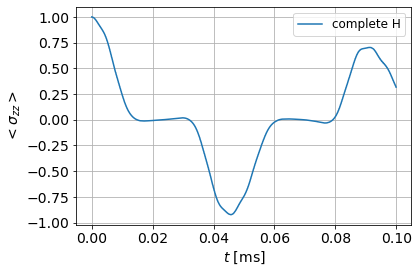

In [10]:
#%% plot spin dynamics
#p1 = expect(elist1[0],result1.states)
#plt.plot(times,p1,label = 'pure spin')
p2 = expect(elist2[0],result2.states)
plt.plot(times,p2,label = 'complete H')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<\sigma_{zz}>$',fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

Maximum phonon population highest com fock state
5.261526507682372e-11


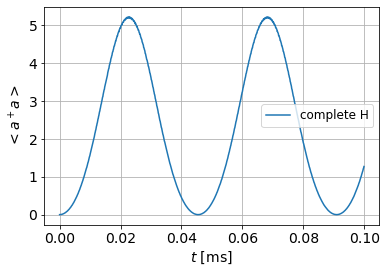

In [11]:
#%% plot phonon dynamics
mp_state1 = expect(sp_op.pstate_measure(ion_sys,laser1,49,0),result2.states) 
pplot = expect(sp_op.phonon_measure(ion_sys,laser1, mindex=0), result2.states)
print('Maximum phonon population highest com fock state')
print(np.max(mp_state1))
plt.plot(times,pplot,label = 'complete H')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<a^+ a>$',fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [12]:
#%% generate frames for gif, use |++> as projector plot
tot_frame = 25
wg.wigner_evol_frames(tot_frame,times,result2, proj1, 2)

start frame generation


D:\Anaconda\lib\site-packages\sigfig\sigfig.py:586: UserWarning: warning: 2 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


percent of tasks completed: 10%
percent of tasks completed: 20%
percent of tasks completed: 30%
percent of tasks completed: 40%
percent of tasks completed: 50%
percent of tasks completed: 60%
percent of tasks completed: 70%
percent of tasks completed: 80%
All tasks finished.


In [13]:
#%% create gif using generated frames
wg.wiger_evol_gif(tot_frame,'2body_PA + .gif',frame_duration=0.5,remove_frame = True)


2body_PA + .gif successfully generated.
Stored at C:\Users\zhumj\Desktop\notebook examples
